In [36]:
from pandas import DataFrame, read_csv
from matplotlib.pyplot import figure, xlabel, ylabel, scatter, show, subplots
import ds_charts as ds

raw_data: DataFrame = read_csv('data/transformed/NYC_collisions_tabular_dumm.csv')
data = raw_data.drop('PERSON_INJURY',axis=1)
data.shape

(45669, 130)

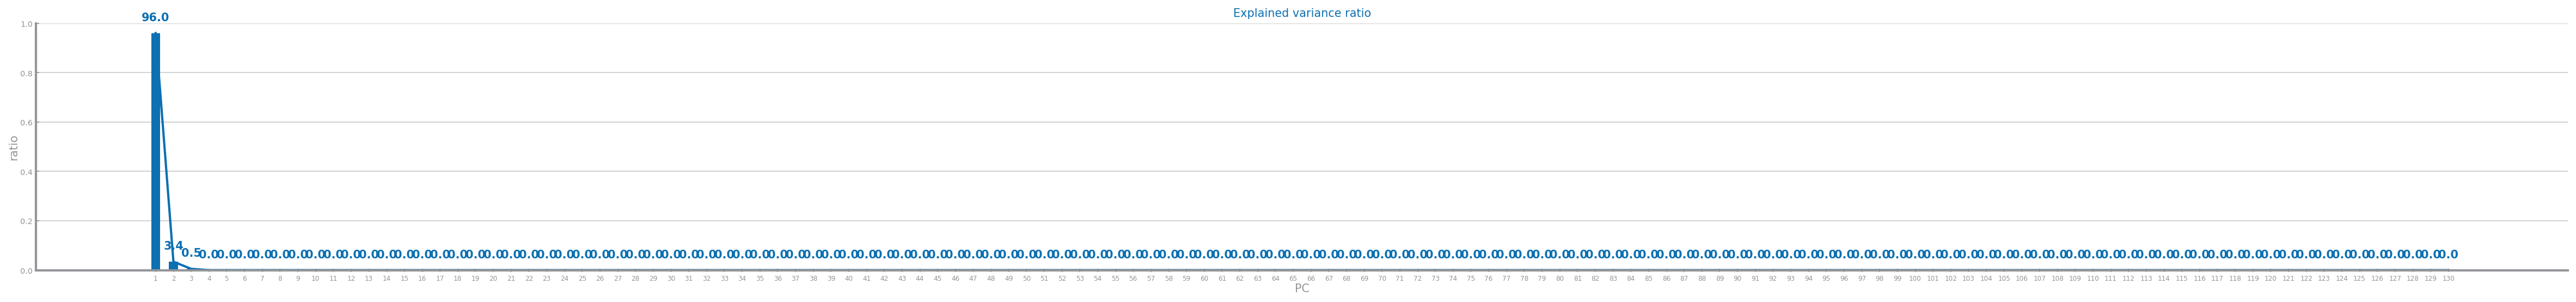

In [37]:
from sklearn.decomposition import PCA
from numpy.linalg import eig
from matplotlib.pyplot import gca, title

mean = (data.mean(axis=0)).tolist()

centered_data = data - mean
cov_mtx = centered_data.cov()
eigvals, eigvecs = eig(cov_mtx)

pca = PCA()
pca.fit(centered_data)
PC = pca.components_
var = pca.explained_variance_

# PLOT EXPLAINED VARIANCE RATIO
fig = figure(figsize=(40, 4))
title('Explained variance ratio')
xlabel('PC')
ylabel('ratio')
x_values = [str(i) for i in range(1, len(pca.components_) + 1)]
bwidth = 0.5
ax = gca()
ax.set_xticklabels(x_values)
ax.set_ylim(0.0, 1.0)
ax.bar(x_values, pca.explained_variance_ratio_, width=bwidth)
ax.plot(pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    ax.text(i, v+0.05, f'{v*100:.1f}', ha='center', fontweight='bold')
show()

In [38]:
transf = pca.transform(data)

aux = DataFrame(transf)
pca_data = aux.iloc[: , :3]
pca_data['PERSON_INJURY'] = raw_data['PERSON_INJURY']
post_data = pca_data
pca_data.to_csv(f'data/transformed/NYC_collisions_pca3.csv', index=False)
pca_data = aux.iloc[: , :2]
pca_data['PERSON_INJURY'] = raw_data['PERSON_INJURY']
pca_data.to_csv(f'data/transformed/NYC_collisions_pca2.csv', index=False)

pca_data.head()

,0,1,PERSON_INJURY
0,-0.981622,36.994033,Injured
1,-0.989015,21.994343,Injured
2,-0.979030,43.008465,Injured
3,-0.966114,67.984480,Injured
4,-0.988946,21.995245,Injured


## Balancing of pca data:

In [39]:
class_var = 'PERSON_INJURY'
target_count = post_data[class_var].value_counts()

target_count = post_data[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

Minority class= Killed : 253
Majority class= Injured : 45416
Proportion: 0.01 : 1


In [40]:
df_positives = post_data[post_data[class_var] == positive_class]
df_negatives = post_data[post_data[class_var] == negative_class]

In [41]:
df_neg_sample = DataFrame(df_negatives.sample(len(df_negatives) // 4))
df_under = concat([df_positives, df_neg_sample], axis=0)
values['UnderSample'] = [len(df_positives), len(df_neg_sample)]
print('Minority class=', positive_class, ':', len(df_positives))
print('Majority class=', negative_class, ':', len(df_neg_sample))
print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')

Minority class= Killed : 253
Majority class= Injured : 11354
Proportion: 0.02 : 1


### Remaining oversampling

In [42]:
from ds_charts import bar_chart

class_var = 'PERSON_INJURY'
target_count = df_under[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

Minority class= Killed : 253
Majority class= Injured : 11354
Proportion: 0.02 : 1


In [43]:
from pandas import Series
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = df_under.pop(class_var).values
X = df_under.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(df_under.columns) + [class_var]
df_smote.to_csv(f'data/pca2_balanced.csv', index=False)

smote_target_count = Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]
print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')

Minority class= Killed : 11354
Majority class= Injured : 11354
Proportion: 1.0 : 1
